In [6]:
import numpy as np
import random
from timeit import default_timer as timer

# Zad1 - Metoda Gaussa-Jordana

In [7]:
def GaussJordan(A, b):
    n = len(A)
    for pivot_row in range(n):        
        for row in list(range(pivot_row)) + list(range(pivot_row + 1, n)):
            multiplicator = -(A[row][pivot_row] / A[pivot_row][pivot_row])
            for col in range(pivot_row, n):
                A[row][col] = A[row][col] + multiplicator * A[pivot_row][col]
            b[row] = b[row] + multiplicator * b[pivot_row]

### Sprawdzenie rozwiązania:

In [8]:
A = np.array([[1., -1., 1., -1.], [1., 3., 6., 8.], [1., 1., 1., 1.], [1., 2., 4., 8.]])
b = np.array([[14.], [4.], [2.], [2.]])

#### Wyniki dla rozwiązania bibliotecznego:

In [9]:
np.linalg.solve(A,b)

array([[ 4.4],
       [-5.2],
       [ 3.6],
       [-0.8]])

#### Wyniki dla rozwiązania moją funkcją Gaussa:

In [10]:
GaussJordan(A, b)

In [13]:
A

array([[ 1. ,  0. ,  0. ,  0. ],
       [ 0. ,  4. ,  0. ,  0. ],
       [ 0. ,  0. , -2.5,  0. ],
       [ 0. ,  0. ,  0. ,  3. ]])

In [14]:
b

array([[  4.4],
       [-20.8],
       [ -9. ],
       [ -2.4]])

In [15]:
np.linalg.solve(A,b)

array([[ 4.4],
       [-5.2],
       [ 3.6],
       [-0.8]])

### Porównanie czasów:

In [16]:
size = 300
A = np.array([[random.uniform(0,20) for _ in range(size)] for _ in range(size)])
b = np.array([random.uniform(0,20) for _ in range(size)])

In [17]:
start = timer()
GaussJordan(np.copy(A),np.copy(b))
end = timer()
print("My Gauss: ", (end - start))
start = timer()
np.linalg.solve(A,b)
end = timer()
print("np.linalg.solve: ", end - start)

My Gauss:  14.619190124998568
np.linalg.solve:  0.0033957689884118736


# Zad 2 - faktoryzacja

##### funkcje pomocnicze:

In [1402]:
def partial_pivot(x, pivot_row):
    return pivot_row + np.argmax(abs(x[:, pivot_row][pivot_row:]/max(x[pivot_row])))

def swap(x, pivot_row, pivot_max):
    temp = np.copy(x[pivot_row])
    x[pivot_row] = x[pivot_max]
    x[pivot_max] = temp
    return x

##### funkcja faktoryzująca macierz A w miejscu:

In [1403]:
def factorLU(A, b):
    n = len(A)
    for pivot_row in range(n):
        pivot_max = partial_pivot(A, pivot_row)
        swap(A, pivot_row, pivot_max)
        
        for row in range(pivot_row + 1, n):
            multiplicator = -(A[row][pivot_row] / A[pivot_row][pivot_row])
            for col in range(pivot_row, n):
                A[row][col] = A[row][col] + (multiplicator * A[pivot_row][col])
            A[row][pivot_row] = -multiplicator
    return A

##### funkcje pomocnicze do ekstrakcji macierzy L i U z macierzy A (faktoryzowanej w miejscu):

In [1404]:
def get_l(A):
    L = A.copy()
    n = L.shape[0]
    for i in range(0, n):
        L[i][i] = 1
        for j in range(i+1, n):
            L[i][j] = 0
    return L

def get_u(A):
    U = A.copy()
    n = U.shape[0]
    for i in range(0, n):
        for j in range(i+1, n):
            U[j][i] = 0
    return U

### Sprawdzenie wyników:

In [1405]:
A = np.array([[1., -1., 1., -1.], [1., 3., 6., 8.], [1., 1., 1., 1.], [1., 2., 4., 8.]])
b = np.array([[14.], [4.], [2.], [2.]])

#### rozwiązanie funkcją biblioteczną:

In [1406]:
np.linalg.solve(A,b)

array([[ 4.4],
       [-5.2],
       [ 3.6],
       [-0.8]])

#### Rozwiązanie równania powstałego poprzez pomnożenie powstałych przez faktoryzację macierzy L oraz U:

In [1407]:
factorLU(A,b)
np.linalg.solve(np.dot(get_l(A),get_u(A)), b)

array([[ 4.4],
       [-5.2],
       [ 3.6],
       [-0.8]])

# Zad 3 - Analiza obwodu elektrycznego

In [697]:
import networkx as nx

In [1204]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

class Circuit:
    def __init__(self, filename, kirchhoff=False):
        self.__kirchoff__ = kirchhoff
#         Metoda Kirchhoffa wymaga grafu skierowanego
        self.graph = nx.DiGraph() if kirchhoff else nx.Graph()
#     Odczytanie danych z pliku:
        with open(filename, 'r') as file:
            self.file_data = file.read()
        self.file_data = self.file_data.splitlines()
#         Wczytanie krawędzi na której umieszczone jest źródło napięcia
        self.sem = list(map(lambda x: int(x), self.file_data[0].split()[:-1])) + [float(self.file_data[0].split()[2])]

#     Wczytanie krawędzi
        for edge_id, node in enumerate(self.file_data):
            node = node.split()
            weight = float(node[2]) if edge_id != 0 else 0
            self.graph.add_edge(int(node[0]), int(node[1]), weight=weight,
                                edge_id=edge_id)

        self.edges = nx.get_edge_attributes(self.graph, 'edge_id')
        self.weights = nx.get_edge_attributes(self.graph, 'weight')
        self.number_of_edges = self.graph.number_of_edges()

    def solve(self):
        if self.__kirchoff__:
#             Metoda z wykorzystaniem praw Kirchhoffa
            self.__solve_Kirchoff__()
        else:
#             Metoda potencjałów węzłowych
            self.__solve_Coltri__()

    def __solve_Kirchoff__(self):
        A = []
        b = []
        # 1 prawo Kirchhoffa:
        for node in self.graph.nodes:
            A.append([0.] * self.number_of_edges)  # tyle będzie niewiadomych (natężenie na każdej krawędzi)
            b.append([0.])

            for successor in self.graph.successors(node):
                A[-1][self.edges[(node, successor)]] -= 1
            for predecessor in self.graph.predecessors(node):
                A[-1][self.edges[(predecessor, node)]] += 1

        # 2 prawo Kirchhoffa:
        for i, cycle in enumerate(nx.cycle_basis(self.graph.to_undirected())):
            A.append([0.] * self.number_of_edges)
            if self.sem[0] in cycle and self.sem[1] in cycle:
                b.append([float(self.sem[2])])
            else:
                b.append([0.])
            for i, node in enumerate(cycle):
                cycle_len = len(cycle)
                edge = (node, cycle[(i + 1) % cycle_len])
                sign = 1
                if edge not in self.edges:
                    edge = (cycle[(i + 1) % cycle_len], node)
                    sign = -1
                A[-1][self.edges[edge]] = sign * float(self.weights[edge])
        
#         Rozwiązanie układu:
        At = np.transpose(A)
        self.I = np.linalg.solve(np.dot(At,A),np.dot(At,b))
        for i in self.I:
            i[0] = abs(i[0])
        self.graph = self.graph.to_undirected()
        self.I = {(u,v): self.I[self.edges[u,v] if (u,v) in self.edges else self.edges[v, u]][0] for u, v in self.graph.edges()}
        return self.I

    def __solve_Coltri__(self):
        A = []
        b = []
        number_of_nodes = self.graph.number_of_nodes();
#         Wyliczenie potencjału dla każdego węzła
        for node in self.graph.nodes:
            A.append([0] * number_of_nodes)
            if node == self.sem[0]:
                b.append([self.sem[2]])
                A[-1][node] = 1
            elif node == self.sem[1]:
                b.append([0.])
                A[-1][node] = 1
            else:
                b.append([0])
                for neighbor in self.graph.neighbors(node):
                    A[-1][node] += 1.0 / self.weights[(node, neighbor) if (node, neighbor) in self.weights else (neighbor, node)]
                    A[-1][neighbor] -= 1 / self.weights[(node, neighbor) if (node, neighbor) in self.weights else (neighbor, node)]
        Q = np.linalg.solve(np.array(A), np.array(b))
        self.I = {}
#         Iij = (Qi-Qj)/Rij
        for u, v in self.graph.edges():
            if (u, v) != (self.sem[0], self.sem[1]) and (v, u) != (self.sem[0], self.sem[1]):
                self.I[(u, v)] = abs((Q[u][0] - Q[v][0]) / (self.weights[(u, v)] if (u, v) in self.weights else self.weights[(v, u)]))
            else:
                i_in_u = 0
                for neighbor in self.graph.neighbors(u):
                    if neighbor != v:
                        i_in_u += abs((Q[u][0] - Q[neighbor][0]) / (self.weights[(u, neighbor)] if (u, neighbor) in self.weights else self.weights[(neighbor, u)]))
                self.I[(u, v)] = abs(i_in_u)

        return self.I
    
    def draw(self, with_labels=False, pos=None, edge_cmap=plt.cm.Wistia, width=2):
        if pos is None:
            pos = nx.spring_layout(self.graph)
        colors = [self.I[edge] for edge in self.graph.edges]

        nx.draw(self.graph, pos, edge_color=colors, edge_cmap=edge_cmap, with_labels=True, width=width)
        if with_labels:
            labels = nx.get_edge_attributes(self.graph, 'weight')
            for label in labels:
                labels[label] = 'R=' + str(round(labels[label], 2)) + ', I=' + str(round(self.I[label], 2))
            labels[(self.sem[0], self.sem[1])] += ', SEM: ' + str(round(self.sem[2], 2))
            nx.draw_networkx_edge_labels(self.graph,pos,edge_labels=labels)
        plt.show()

## Generowanie grafów

In [752]:
import random

In [1217]:
def generateRandomGraph(number_of_nodes, maxDegreeOutFromVertex=2, maxResistance=50, offset=0):    
    G = {}
    for u in range(offset, offset + number_of_nodes):
        for j in range(random.randint(1, maxDegreeOutFromVertex)):
            v = u
            while(v == u):
                v = random.randint(offset, offset + number_of_nodes - 1)
            if not (u,v) in G and not (v,u) in G:
                G[(u, v)] = random.random() * maxResistance
    if offset == 0:
        for i in G:
            G[i] *= 2*number_of_nodes
            break
    return G

In [1089]:
def writeToFile(G, filename):
    a = []
    for key in G.keys():
        a.append([*key,G[key]])
    a.sort()

    with open(filename, 'w') as f:
        f.write('\n'.join(list(map(lambda x: ' '.join(list(map(lambda el: str(el), x))), a))))

## Sprawdzenie działania:

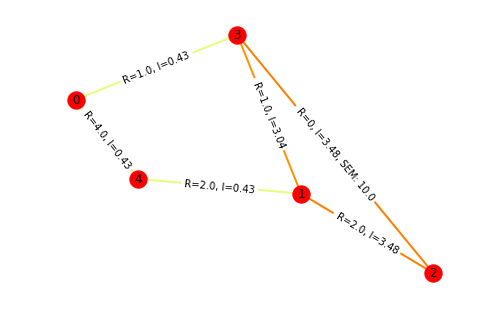

In [748]:
a = Circuit('data', kirchhoff=False)
a.solve()
a.draw(with_labels=True)

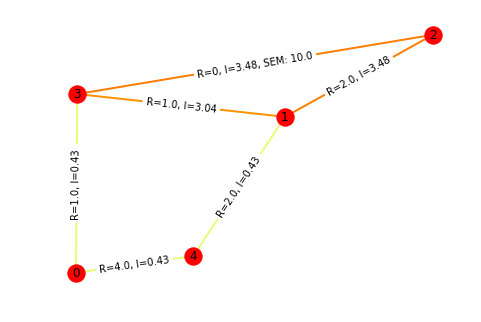

In [955]:
a = Circuit('data', kirchhoff=True)
a.solve()
a.draw(with_labels=True)

## Graf losowy:

In [1359]:
G = generateRandomGraph(6, maxDegreeOutFromVertex=2)
writeToFile(G, 'random')
G

{(0, 3): 464.8580890805197,
 (0, 4): 38.73443486755208,
 (1, 0): 8.149407414161903,
 (1, 2): 1.851071573963392,
 (2, 3): 49.450184733930634,
 (3, 5): 36.60198744118554,
 (4, 1): 6.804951569991108,
 (5, 4): 23.220707117545057}

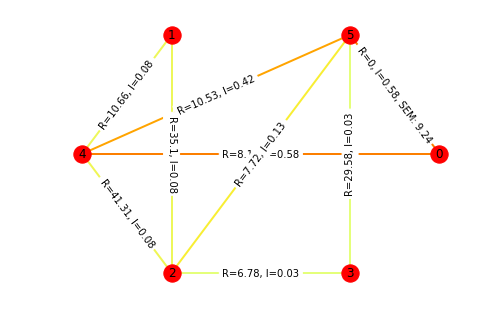

In [1022]:
a = Circuit('random', kirchhoff=False)
a.solve()
a.draw(with_labels=True, pos=nx.circular_layout(a.graph))

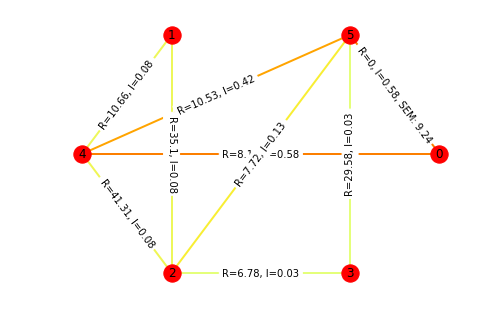

In [1023]:
a = Circuit('random', kirchhoff=True)
a.solve()
a.draw(with_labels=True, pos=nx.circular_layout(a.graph))

## Graf 3-regularny:

### 8-wierzchołkowy graf z biblioteki:

In [ ]:
to_write = ''
for u,v in nx.cubical_graph().edges:
    to_write += '''{} {} {}\n'''.format(str(u), str(v), str(random.random() * 20))
with open('cubic', 'w') as f:
    f.write(to_write)

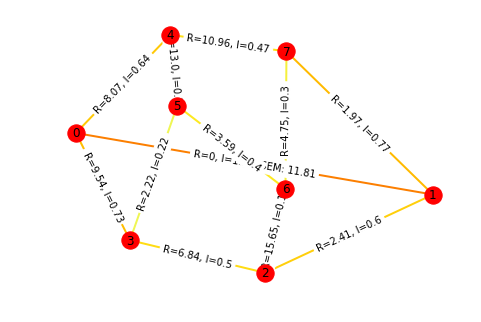

In [1072]:
a = Circuit('cubic', kirchhoff=True)
a.solve()
a.draw(with_labels=True, pos=nx.fruchterman_reingold_layout(a.graph))

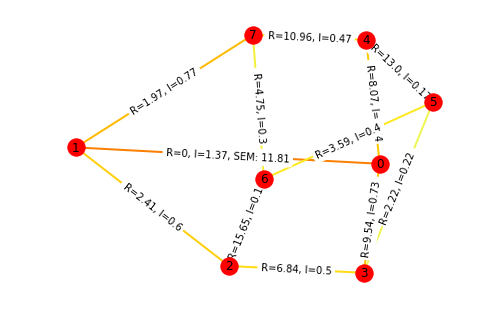

In [1073]:
a = Circuit('cubic', kirchhoff=False)
a.solve()
a.draw(with_labels=True, pos=nx.fruchterman_reingold_layout(a.graph))

### Graf kubiczny:

In [1184]:
def generateCubicalGraph(vertex_num=8, max_resistance=40):
    if vertex_num % 2 != 0:
        raise Exception("vertex_num must be even")
    G = {}
    for u in range(vertex_num):
        G[(u, (u+1)%vertex_num)] = random.random() * max_resistance
        if ((u + (vertex_num / 2)) % vertex_num, u) not in G:
            G[(u, (u + (vertex_num // 2)) % vertex_num)] = random.random() * max_resistance
    for i in G:
        G[i] *= vertex_num
        break
    return G

In [1185]:
G = generateCubicalGraph(vertex_num=16)
writeToFile(G, 'myCubical')

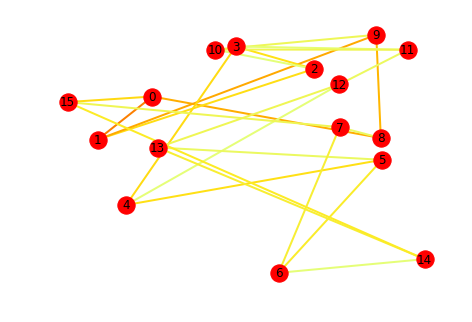

In [1186]:
a = Circuit('myCubical', kirchhoff=False)
a.solve()
a.draw(with_labels=False, pos=nx.random_layout(a.graph))

##### natężenia:

In [1187]:
a.I

{(0, 1): 19.276898780510159,
 (0, 8): 12.480769823915194,
 (0, 15): 6.7961289565949654,
 (1, 2): 6.2276522149178763,
 (1, 9): 13.0492465655923,
 (2, 3): 5.8379469463127256,
 (2, 10): 0.38970526860515214,
 (3, 4): 6.5584580576445868,
 (3, 11): 0.72051111133184631,
 (4, 5): 5.96936488410135,
 (4, 12): 0.58909317354317958,
 (5, 6): 4.3229701385267596,
 (5, 13): 1.64639474557458,
 (6, 7): 3.7847013600065451,
 (6, 14): 0.53826877852020671,
 (7, 15): 2.260953281590218,
 (8, 7): 1.5237480784163482,
 (8, 9): 10.957021745498841,
 (9, 10): 2.0922248200934592,
 (10, 11): 2.4819300886986091,
 (11, 12): 1.7614189773667601,
 (12, 13): 2.350512150909938,
 (13, 14): 3.9969068964845174,
 (14, 15): 4.5351756750047185}

##### Opory:

In [1188]:
a.weights

{(0, 1): 0,
 (0, 8): 6.0340134520321875,
 (0, 15): 10.046052567949815,
 (1, 2): 23.660419808642917,
 (1, 9): 7.779917020615739,
 (2, 3): 14.571357499012013,
 (2, 10): 25.413007077084593,
 (3, 4): 1.4811103421735927,
 (3, 11): 5.082873435715327,
 (4, 5): 11.711889380838407,
 (4, 12): 32.00388128300056,
 (5, 6): 26.805215349977985,
 (5, 13): 21.421261943347908,
 (6, 7): 25.461662589773347,
 (6, 14): 2.9645172550758847,
 (7, 15): 8.237213468193056,
 (8, 7): 7.605647372767943,
 (8, 9): 39.64142801201697,
 (9, 10): 26.63690468592629,
 (10, 11): 28.808612621120695,
 (11, 12): 18.297370046903225,
 (12, 13): 36.72694322360333,
 (13, 14): 20.567404149875333,
 (14, 15): 25.003008680959958}

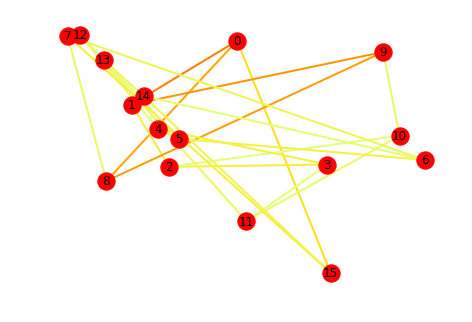

In [1251]:
a = Circuit('myCubical', kirchhoff=True)
a.solve()
a.draw(with_labels=False, pos=nx.random_layout(a.graph))

##### Natężenia:

In [1252]:
a.I

{(0, 1): 33.309291786395562,
 (0, 8): 23.119471834100032,
 (0, 15): 10.189819952298098,
 (1, 2): 5.7944695441142153,
 (1, 9): 27.514822242278786,
 (2, 3): 5.9124449725983004,
 (2, 10): 0.1179754284857428,
 (3, 4): 5.3480063737807182,
 (3, 11): 0.56443859881667469,
 (4, 5): 5.794788111055607,
 (4, 12): 0.44678173727526682,
 (5, 6): 4.8243002389638807,
 (5, 13): 0.97048787209112863,
 (6, 7): 3.639336998773822,
 (6, 14): 1.1849632401921291,
 (7, 15): 6.0600549118572777,
 (8, 7): 2.420717913078724,
 (8, 9): 25.540189747180023,
 (9, 10): 1.9746324950963972,
 (10, 11): 1.8566570666085889,
 (11, 12): 2.4210956654266855,
 (12, 13): 1.9743139281526252,
 (13, 14): 2.9448018002406178,
 (14, 15): 4.1297650404358519}

##### Opory:

In [1253]:
a.weights

{(0, 1): 0,
 (0, 8): 10.6220680878087,
 (1, 2): 26.181751909904946,
 (1, 9): 2.6738818915996543,
 (2, 3): 6.811278434220207,
 (2, 10): 17.825518241982167,
 (3, 4): 8.681197368174836,
 (3, 11): 26.080217132850294,
 (4, 5): 5.8652039320733484,
 (4, 12): 28.855739236488397,
 (5, 6): 14.69194804061166,
 (5, 13): 11.716581957436457,
 (6, 7): 20.859053013368204,
 (6, 14): 21.61582848651303,
 (7, 8): 27.763530327423844,
 (7, 15): 0.8944821515379742,
 (8, 9): 10.900773264111884,
 (9, 10): 38.505902311202235,
 (10, 11): 30.751485737504673,
 (11, 12): 7.770944619815596,
 (12, 13): 29.504240020985332,
 (13, 14): 28.905690667186615,
 (14, 15): 13.492237848532733,
 (15, 0): 16.972656890476834}

## Graf z mostkiem:

In [1342]:
maxResistance=20
G = generateRandomGraph(10, maxResistance=maxResistance, maxDegreeOutFromVertex=3)
G1 = generateRandomGraph(10, offset=10, maxResistance=maxResistance)
G2 = {**G, **G1}
G2 [(1,10)] = random.random() * maxResistance
writeToFile(G2, 'Bridge')

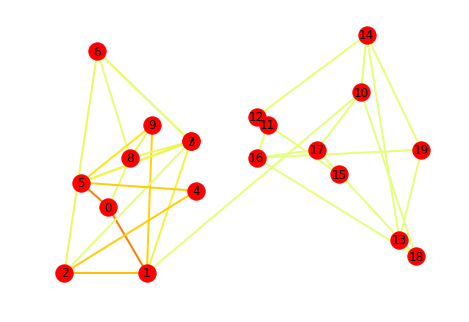

In [1343]:
a = Circuit('Bridge', kirchhoff=False)
a.solve()
pos = {}
for node in a.graph.nodes:
    pos[node] = (random.randint(0,30),random.randint(0,30)) if node < 10 else (random.randint(40,70), random.randint(0,30))
a.draw(with_labels=False, pos=pos)

In [1347]:
a.sem

[0, 1, 18.703158051382104]

In [1344]:
a.I

{(0, 1): 2.7638467952866916,
 (0, 5): 2.7033591094834071,
 (0, 8): 0.060487685803284612,
 (1, 2): 1.3701139900996802,
 (1, 7): 0.35009834623375491,
 (1, 9): 1.0436344589532529,
 (1, 10): 0.0,
 (2, 4): 1.1320458013158372,
 (2, 6): 0.2259317887879273,
 (2, 7): 0.012136399995916661,
 (3, 5): 0.29185772192133874,
 (5, 4): 1.1320458013158368,
 (6, 3): 0.2918577219213383,
 (6, 7): 0.022896008829770942,
 (7, 5): 0.52793638652001951,
 (8, 6): 0.043029924303640305,
 (8, 7): 0.18859764912011737,
 (8, 9): 0.29211525922704301,
 (9, 5): 0.75151919972620973,
 (10, 14): 0.0,
 (10, 17): 0.0,
 (10, 18): 0.0,
 (11, 16): 0.0,
 (12, 15): 0.0,
 (13, 18): 0.0,
 (13, 19): 0.0,
 (14, 12): 0.0,
 (14, 13): 0.0,
 (14, 19): 0.0,
 (16, 17): 0.0,
 (16, 18): 0.0,
 (16, 19): 0.0,
 (18, 17): 0.0}

In [1345]:
a.weights

{(0, 1): 0,
 (0, 5): 2.9303609161385435,
 (0, 8): 239.10995754543296,
 (1, 2): 3.238714220636334,
 (1, 7): 12.879566140614692,
 (1, 9): 3.552230700180925,
 (1, 10): 13.949395194593695,
 (2, 4): 3.9751462983066554,
 (2, 6): 2.161605472856447,
 (2, 7): 5.908435980436679,
 (3, 5): 5.97883332669795,
 (5, 4): 1.6288076262274198,
 (6, 3): 14.084220278161501,
 (6, 7): 18.19829175579303,
 (7, 5): 11.880646094450466,
 (8, 6): 15.938512533464975,
 (8, 7): 1.4271903194763835,
 (8, 9): 1.8236626990537652,
 (9, 5): 9.413079283112907,
 (10, 14): 0.5559709179102001,
 (10, 17): 19.244283114186203,
 (10, 18): 2.8419846548091243,
 (11, 16): 7.283441124648197,
 (12, 15): 4.536720461672854,
 (13, 18): 15.377993792506215,
 (13, 19): 19.835615405723512,
 (14, 12): 2.3868445376909087,
 (14, 13): 4.38842793734633,
 (14, 19): 3.6888050377450154,
 (16, 17): 18.487410938807237,
 (16, 18): 7.6226995634820955,
 (16, 19): 8.75135592760955,
 (18, 17): 2.6118182222266006}

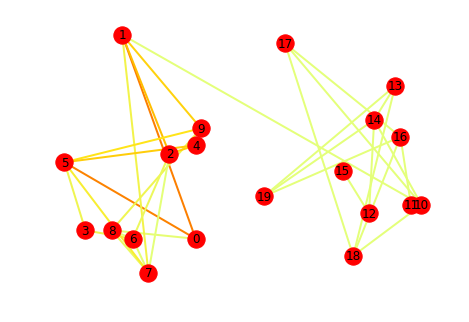

In [1355]:
a = Circuit('Bridge', kirchhoff=True)
a.solve()
pos = {}
for node in a.graph.nodes:
    pos[node] = (random.randint(0,30),random.randint(0,30)) if node < 10 else (random.randint(40,70), random.randint(0,30))
a.draw(with_labels=False, pos=pos)

In [1356]:
a.sem

[0, 1, 18.703158051382104]

##### Natężenia:

In [1357]:
a.I

{(0, 1): 2.7638467952866881,
 (0, 5): 2.7033591094834062,
 (0, 8): 0.060487685803284792,
 (1, 2): 1.3701139900996617,
 (1, 7): 0.35009834623375174,
 (1, 9): 1.0436344589532465,
 (1, 10): 2.4571303140385846e-14,
 (2, 4): 1.1320458013158454,
 (2, 6): 0.2259317887879172,
 (2, 7): 0.012136399995916649,
 (3, 5): 0.29185772192133497,
 (5, 4): 1.1320458013158456,
 (6, 3): 0.29185772192134479,
 (6, 7): 0.022896008829769787,
 (7, 5): 0.52793638652002317,
 (8, 6): 0.043029924303638875,
 (8, 7): 0.18859764912011939,
 (8, 9): 0.2921152592270343,
 (9, 5): 0.75151919972621239,
 (10, 14): 1.3536564721270972e-14,
 (10, 17): 1.224095784419159e-15,
 (10, 18): 6.5817053782575698e-15,
 (11, 16): 2.3728058588479992e-15,
 (12, 15): 2.3691489234058636e-15,
 (13, 18): 3.0667245254213605e-18,
 (13, 19): 1.6283676060736293e-16,
 (14, 12): 4.7382978468117312e-15,
 (14, 13): 2.5362066890609968e-15,
 (14, 19): 3.8929112619923914e-15,
 (16, 17): 7.0752518705402139e-16,
 (16, 18): 2.3525798882655837e-15,
 (16, 19): 

Metoda Kirchhoffa ma mniejszą dokładność, ze względu na nadokreślony układ równań oraz rozwiązanie go poprzez
pomnożenie stronami poprzez transponowaną macierz współczynników

##### Opory:

In [1358]:
a.weights

{(0, 1): 0,
 (0, 8): 239.10995754543296,
 (1, 9): 3.552230700180925,
 (1, 10): 13.949395194593695,
 (2, 1): 3.238714220636334,
 (2, 6): 2.161605472856447,
 (2, 7): 5.908435980436679,
 (3, 5): 5.97883332669795,
 (3, 6): 14.084220278161501,
 (4, 2): 3.9751462983066554,
 (4, 5): 1.6288076262274198,
 (5, 0): 2.9303609161385435,
 (5, 9): 9.413079283112907,
 (6, 7): 18.19829175579303,
 (6, 8): 15.938512533464975,
 (7, 1): 12.879566140614692,
 (7, 5): 11.880646094450466,
 (7, 8): 1.4271903194763835,
 (8, 9): 1.8236626990537652,
 (10, 14): 0.5559709179102001,
 (11, 16): 7.283441124648197,
 (12, 14): 2.3868445376909087,
 (13, 14): 4.38842793734633,
 (13, 18): 15.377993792506215,
 (14, 19): 3.6888050377450154,
 (15, 12): 4.536720461672854,
 (16, 18): 7.6226995634820955,
 (17, 10): 19.244283114186203,
 (17, 16): 18.487410938807237,
 (18, 10): 2.8419846548091243,
 (18, 17): 2.6118182222266006,
 (19, 13): 19.835615405723512,
 (19, 16): 8.75135592760955}

### Siatka 2D:

In [1422]:
def generate2DGrid(x_size,y_size, maxResistance=50):
    G = {}
    for i in range(x_size * y_size):
        if (i + 1) % x_size != 0:
            G[(i, i+1)] = random.random() * maxResistance
        if i < x_size * (y_size - 1):
            G[(i, i + x_size)] = random.random() * maxResistance
    G[(0,1)] = maxResistance**2
    return G

In [1429]:
x_size = 5
y_size = 7
G = generate2DGrid(x_size,y_size)
writeToFile(G, '2DGrid')

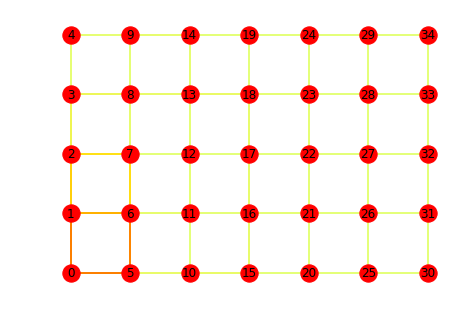

In [1430]:
a = Circuit('2DGrid', kirchhoff=True)
a.solve()
pos = {}
for node in a.graph.nodes:
    pos[node] = (30 * (node // x_size), 30 * (node % x_size))
a.draw(with_labels=False, pos=pos)

##### natężenia:

In [1434]:
a.I

{(0, 1): 91.415332657877784,
 (0, 5): 91.415332657877443,
 (1, 2): 36.265049019183024,
 (1, 6): 55.1502836386951,
 (2, 3): 9.7171107281363884,
 (2, 7): 26.547938291047558,
 (3, 4): 1.5563835915201745,
 (3, 8): 8.1607271366232919,
 (4, 9): 1.5563835915316671,
 (5, 6): 87.158575283183481,
 (5, 10): 4.2567573746884424,
 (6, 7): 28.92207619668444,
 (6, 11): 3.0862154477993298,
 (7, 8): 2.929813843511067,
 (7, 12): 0.55567593787807934,
 (8, 9): 1.2276486420062109,
 (8, 13): 4.0032646511129002,
 (9, 14): 2.7840322335454259,
 (10, 11): 0.31235141264839206,
 (10, 15): 4.5691087873368481,
 (11, 12): 1.7321460743679653,
 (11, 16): 1.0417179607801998,
 (12, 13): 1.2109590146443254,
 (12, 17): 0.034488878159388517,
 (13, 14): 2.1267857966543593,
 (13, 18): 4.9190914331227029,
 (14, 19): 0.65724643689561446,
 (15, 16): 3.8697149307413308,
 (15, 20): 0.69939385659554376,
 (16, 17): 3.5474847532134235,
 (16, 21): 1.3639481383086651,
 (17, 18): 3.5113448178583289,
 (17, 22): 0.0016510571960993506,
 (1

##### Opory:

In [1435]:
a.weights

{(0, 1): 0,
 (0, 5): 16.790281698963383,
 (1, 2): 7.3341428758621205,
 (1, 6): 15.022221937680719,
 (2, 3): 31.130270193883813,
 (2, 7): 16.83477325097241,
 (3, 4): 7.481437796990575,
 (3, 8): 0.726185823547193,
 (4, 9): 30.85249094760354,
 (5, 6): 1.5676141088739548,
 (5, 10): 38.81337357074196,
 (6, 7): 3.996194036800987,
 (6, 11): 6.784806312993874,
 (7, 8): 47.27468773831131,
 (7, 12): 25.9840911601898,
 (8, 9): 43.77155767685817,
 (8, 13): 32.5772882745222,
 (9, 14): 21.06599058733488,
 (10, 11): 24.487572321769235,
 (10, 15): 0.20303234939463843,
 (11, 12): 46.30101429495321,
 (11, 16): 31.818515002185187,
 (12, 13): 18.604479555258123,
 (12, 17): 40.60424352201906,
 (13, 14): 8.47805944523326,
 (13, 18): 3.773904698038849,
 (14, 19): 41.868430661037614,
 (15, 16): 6.349179281703988,
 (15, 20): 38.31775103056887,
 (16, 17): 12.869345453335123,
 (16, 21): 11.43711632184104,
 (17, 18): 1.5280398384568628,
 (17, 22): 28.86712066862531,
 (18, 19): 26.16642583362543,
 (18, 23): 0.7899